In [3]:
import os
import gc
import time
import pickle
import datetime
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask import delayed, compute
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import preprocessing, metrics
import lightgbm as lgb
from textblob import TextBlob

path = "F:\\Pratik\\LearningZone\\Competitions\\Avito_Demand_Prediction_Challenge"
os.chdir(path)

C:\Program Files\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
train_df = pd.read_csv('train_translated.csv', parse_dates=['activation_date'])
test_df = pd.read_csv('test_translated.csv', parse_dates=['activation_date'])

In [4]:
total_df = pd.read_csv('total_translated.csv', parse_dates=['activation_date'])

In [9]:
train_df['dow'] = train_df['activation_date'].dt.weekday
test_df['dow'] = test_df['activation_date'].dt.weekday

In [5]:
total_df['dow'] = total_df['activation_date'].dt.weekday

In [ ]:
train_df.head()

In [6]:
cat_vars = ["en_region", "en_city", "en_parent_category_name", "en_category_name", "user_type", "en_param1", "en_param2", "en_param3"]

In [7]:
def label_encoding(train_data, categorical_feature_names):
    le = preprocessing.LabelEncoder() # Defining Label Encoder
    train_cat_features = np.array(train_data[categorical_feature_names])
    train_data_array = le.fit_transform(train_cat_features[:,0])
    for i in range(1,train_cat_features.shape[1]):
        train_data_array = np.column_stack((train_data_array, le.fit_transform(train_cat_features[:,i])))
        
    train_cat_data_df = pd.DataFrame(train_data_array, columns=categorical_feature_names)
    return train_cat_data_df[categorical_feature_names]

In [8]:
total_df[['en_param1','en_param2','en_param3']].fillna('Missing', inplace=True)

C:\Program Files\Anaconda\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [13]:
train_df[['en_param1','en_param2','en_param3']].fillna('Missing', inplace=True)
test_df[['en_param1','en_param2','en_param3']].fillna('Missing', inplace=True)

C:\Program Files\Anaconda\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [9]:
total_df['en_param1'] = total_df['en_param1'].map(str)
total_df['en_param2'] = total_df['en_param2'].map(str)
total_df['en_param3'] = total_df['en_param3'].map(str)

In [14]:
train_df['en_param1'] = train_df['en_param1'].map(str)
train_df['en_param2'] = train_df['en_param2'].map(str)
train_df['en_param3'] = train_df['en_param3'].map(str)

In [15]:
test_df['en_param1'] = test_df['en_param1'].map(str)
test_df['en_param2'] = test_df['en_param2'].map(str)
test_df['en_param3'] = test_df['en_param3'].map(str)

In [10]:
Catg_Var_LE = label_encoding(total_df, cat_vars)

In [16]:
Catg_Var_LE_train = label_encoding(train_df,cat_vars)
Catg_Var_LE_test = label_encoding(test_df,cat_vars)

In [11]:
# Dropping the rows on which One-Hot Encoding has been performed
total_df = total_df.drop(Catg_Var_LE.columns, axis=1)
# Concating the rows converted using One-Hot Encoding to other columns:
total_df = pd.concat([total_df,Catg_Var_LE], axis=1)

In [17]:
# Dropping the rows on which One-Hot Encoding has been performed
train_df = train_df.drop(Catg_Var_LE_train.columns, axis=1)
# Concating the rows converted using One-Hot Encoding to other columns:
train_df = pd.concat([train_df,Catg_Var_LE_train], axis=1)

In [18]:
# Dropping the rows on which One-Hot Encoding has been performed
test_df = test_df.drop(Catg_Var_LE_test.columns, axis=1)
# Concating the rows converted using One-Hot Encoding to other columns:
test_df = pd.concat([test_df,Catg_Var_LE_test], axis=1)

In [12]:
train_df = total_df[total_df['set'] == 'train']
test_df = total_df[total_df['set'] == 'test']

In [13]:
target = 'deal_probability'
predictors = ['dow', 'en_region', 'en_city',
       'en_parent_category_name', 'en_category_name', 'user_type', 'en_param1',
       'en_param2', 'en_param3','price_new']

In [14]:
# Splitting the data for model training#
dev_X = train_df.iloc[:-200000,:]
val_X = train_df.iloc[-200000:,:]

In [117]:
def run_lgb(train_X, val_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X[predictors].values, label=train_X[target].values)
    lgval = lgb.Dataset(val_X[predictors].values, label=val_X[target].values)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, valid_sets=[lgtrain, lgval], early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
    
    #pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return model, evals_result

In [99]:
params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }

In [ ]:
num_leaves = [20, 25, 30, 35, 40]
learning_rate = [0.01, 0.05, 0.1, 0.15, 0.2]
bst_results = []
for num_lv in num_leaves:
    for lr in learning_rate:
        new_params = {"num_leaves" : num_lv, "learning_rate" : lr}
        params.update(new_params)
        lgtrain = lgb.Dataset(train_X[predictors].values, label=train_X[target].values)
        lgval = lgb.Dataset(val_X[predictors].values, label=val_X[target].values)
        evals_result = {}
        model = lgb.train(params, lgtrain, 1000, valid_sets=[lgtrain, lgval], early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
        bst_results.append(params, )

In [107]:
model = lgb.LGBMRegressor(objective="regression",
        metric = "rmse",
        num_leaves = 30,
        learning_rate = 0.1,
        bagging_fraction = 0.7,
        feature_fraction = 0.7,
        bagging_frequency = 5,
        bagging_seed = 2018,
        verbosity = -1)

In [108]:
params_opt = {'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2], "num_leaves" : [20, 25, 30, 35, 40]}

In [110]:
gridSearchCV = GridSearchCV(estimator = model, 
    param_grid = params_opt, verbose=1)

In [111]:
gridSearchCV.fit(train_df[predictors],train_df[target])

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 13.3min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LGBMRegressor(bagging_fraction=0.7, bagging_frequency=5, bagging_seed=2018,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.7, learning_rate=0.1, max_depth=-1,
       metric='rmse', min_child_samples=20, min_child_weight=0.001,
       min_spl...da=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1, verbosity=-1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2], 'num_leaves': [20, 25, 30, 35, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [114]:
gridSearchCV.grid_scores_

C:\Program Files\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.13209, std: 0.00041, params: {'learning_rate': 0.01, 'num_leaves': 20},
 mean: 0.13629, std: 0.00032, params: {'learning_rate': 0.01, 'num_leaves': 25},
 mean: 0.13980, std: 0.00031, params: {'learning_rate': 0.01, 'num_leaves': 30},
 mean: 0.14259, std: 0.00033, params: {'learning_rate': 0.01, 'num_leaves': 35},
 mean: 0.14508, std: 0.00032, params: {'learning_rate': 0.01, 'num_leaves': 40},
 mean: 0.18440, std: 0.00095, params: {'learning_rate': 0.05, 'num_leaves': 20},
 mean: 0.18848, std: 0.00082, params: {'learning_rate': 0.05, 'num_leaves': 25},
 mean: 0.19178, std: 0.00084, params: {'learning_rate': 0.05, 'num_leaves': 30},
 mean: 0.19479, std: 0.00109, params: {'learning_rate': 0.05, 'num_leaves': 35},
 mean: 0.19652, std: 0.00107, params: {'learning_rate': 0.05, 'num_leaves': 40},
 mean: 0.19442, std: 0.00125, params: {'learning_rate': 0.1, 'num_leaves': 20},
 mean: 0.19837, std: 0.00145, params: {'learning_rate': 0.1, 'num_leaves': 25},
 mean: 0.20112, std: 0.00129, 

In [118]:
model, result = run_lgb(dev_X, val_X)

Training until validation scores don't improve for 100 rounds.
[20]	training's rmse: 0.235874	valid_1's rmse: 0.236164
[40]	training's rmse: 0.233528	valid_1's rmse: 0.233838
[60]	training's rmse: 0.232553	valid_1's rmse: 0.232909
[80]	training's rmse: 0.231928	valid_1's rmse: 0.232326
[100]	training's rmse: 0.23145	valid_1's rmse: 0.231907
[120]	training's rmse: 0.231133	valid_1's rmse: 0.231645
[140]	training's rmse: 0.23081	valid_1's rmse: 0.231372
[160]	training's rmse: 0.23058	valid_1's rmse: 0.231213
[180]	training's rmse: 0.230325	valid_1's rmse: 0.23102
[200]	training's rmse: 0.230132	valid_1's rmse: 0.230926
[220]	training's rmse: 0.229936	valid_1's rmse: 0.230789
[240]	training's rmse: 0.229731	valid_1's rmse: 0.230661
[260]	training's rmse: 0.229565	valid_1's rmse: 0.230568
[280]	training's rmse: 0.229403	valid_1's rmse: 0.230487
[300]	training's rmse: 0.229257	valid_1's rmse: 0.230412
[320]	training's rmse: 0.229123	valid_1's rmse: 0.230344
[340]	training's rmse: 0.228977	v

In [119]:
test_df['deal_probability'] = model.predict(test_df[predictors])

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [122]:
test_df[['item_id','deal_probability']].to_csv('base_submission_total_numleaves40.csv', index=False)

In [35]:
len(test_df)

508438

In [121]:
test_df.deal_probability[test_df['deal_probability'] < 0] = 0

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Program Files\Anaconda\lib\site-packages\pandas\core\generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Program Files\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2910: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns

In [30]:
import kaggle

In [123]:
!kaggle competitions submit -c avito-demand-prediction -f base_submission_total_numleaves40.csv -m "Increasing number of leaves"

Successfully submitted to Avito Demand Prediction Challenge


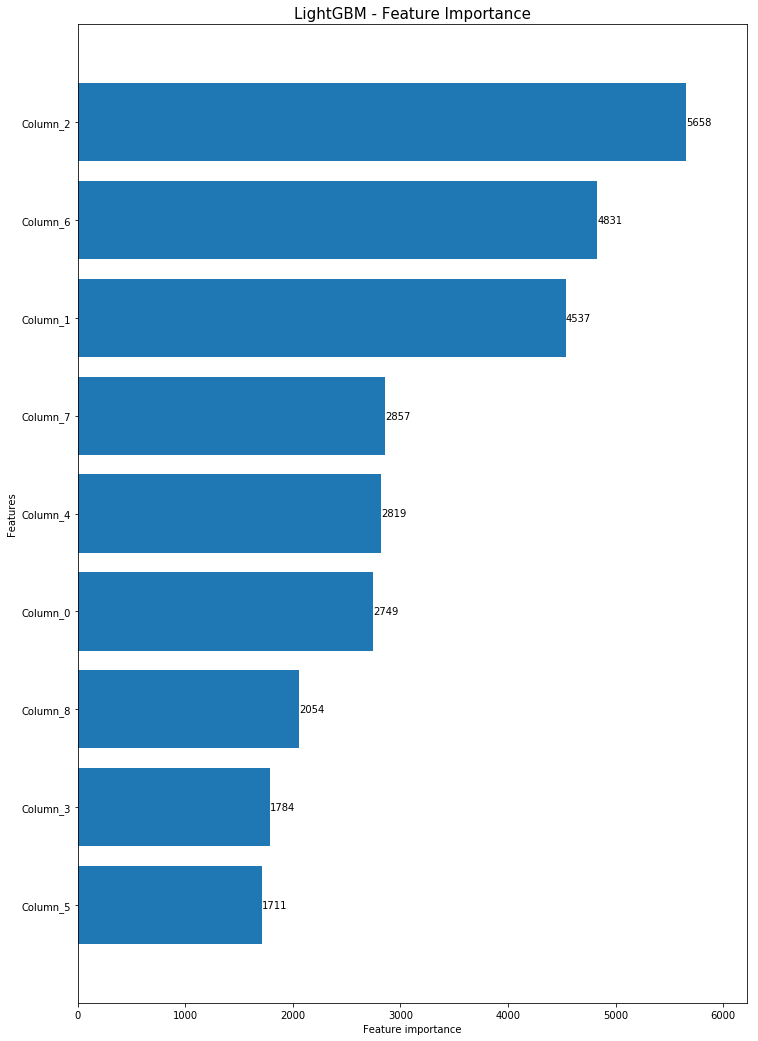

In [23]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

### Running XGBoost:

In [2]:
import xgboost as xgb

In [15]:
len(val_X)

200000

In [16]:
len(dev_X)

1303424

In [17]:
train_dmatrix = xgb.DMatrix(dev_X[predictors],dev_X[target])
valid_dmatrix = xgb.DMatrix(val_X[predictors],val_X[target])

In [22]:
def run_xgb(train_dmatrix, valid_dmatrix):
    params = {
        "objective" : "reg:linear",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    evals_result = {}
    evallist = [(train_dmatrix,'train'), (valid_dmatrix, 'eval')]
    model = xgb.train(params, train_dmatrix, 5000, evallist, early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
    
    #pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return model, evals_result

In [23]:
model, result = run_xgb(train_dmatrix, valid_dmatrix)

[0]	train-rmse:0.413653	eval-rmse:0.413988
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[20]	train-rmse:0.239864	eval-rmse:0.240212
[40]	train-rmse:0.234516	eval-rmse:0.234885
[60]	train-rmse:0.233202	eval-rmse:0.233662
[80]	train-rmse:0.232472	eval-rmse:0.233015
[100]	train-rmse:0.231816	eval-rmse:0.232434
[120]	train-rmse:0.231309	eval-rmse:0.232008
[140]	train-rmse:0.231038	eval-rmse:0.231827
[160]	train-rmse:0.230688	eval-rmse:0.231553
[180]	train-rmse:0.230423	eval-rmse:0.231351
[200]	train-rmse:0.230169	eval-rmse:0.231178
[220]	train-rmse:0.229869	eval-rmse:0.23097
[240]	train-rmse:0.229721	eval-rmse:0.230887
[260]	train-rmse:0.229517	eval-rmse:0.230774
[280]	train-rmse:0.229356	eval-rmse:0.230675
[300]	train-rmse:0.229171	eval-rmse:0.230552
[320]	train-rmse:0.229	eval-rmse:0.230462
[340]	train-rmse:0.228844	eval-rmse:0.230374
[360]	train-rmse:0.2287	eval-rmse:0.230312
[380]	train-r

In [27]:
test_dmatrix = xgb.DMatrix(test_df[predictors])

In [28]:
preds = model.predict(test_dmatrix)

In [30]:
test_df['deal_probability'] = preds

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:
test_df.deal_probability[test_df['deal_probability'] < 0] = 0

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Program Files\Anaconda\lib\site-packages\pandas\core\generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Program Files\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2910: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns

In [33]:
test_df[['item_id','deal_probability']].to_csv('base_submission_xgb_05072018.csv', index=False)

In [34]:
!kaggle competitions submit -c avito-demand-prediction -f base_submission_xgb_05072018.csv -m "base submission xgb model"

Successfully submitted to Avito Demand Prediction Challenge
